# imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# load data and create pandas table

In [2]:
ls *_results

deeprelu_results          new_targets_results
middlelinear_SIM_results  new_targets_SGD_results


In [3]:
res_standard = pd.read_pickle("new_targets_results")
res_deeprelu = pd.read_pickle("deeprelu_results")
res_middlelinear = pd.read_pickle("middlelinear_SIM_results")
print(res_deeprelu.shape,res_standard.shape,res_middlelinear.shape)

(288, 32) (1728, 32) (288, 32)


In [4]:
res_standard[(res_standard.r==1) * (res_standard.sigma<=0.25)].shape

(288, 32)

In [5]:
res = pd.concat([
    res_standard[(res_standard.r==1) * (res_standard.sigma<=0.25)], #filter to just the r and sigma vals we ran everything on
    res_deeprelu[res_deeprelu.L>2], #only look at the actually deep models with these architectures
    # res_middlelinear[res_middlelinear.L>2]
])
res.loc[res.L==2,"Activations"] = "Shallow"

In [6]:
res.Activations.unique()

array(['Shallow', 'standard', 'relus'], dtype=object)

In [7]:
res.loc[res.Activations == "standard","Activations"] = "Linear Layers then ReLU"
res.loc[res.Activations == "relus","Activations"] = "Deep ReLU"
res.loc[res.Activations == "middlelinear","Activations"] = "ReLU then Linear Layers then ReLU"

In [8]:
res.Activations.unique()

array(['Shallow', 'Linear Layers then ReLU', 'Deep ReLU'], dtype=object)

In [9]:
res.shape

(540, 32)

# Check if Final Training Loss is Okay

In [10]:
trainMSE_threshold=1e-2
assert sum(res["Final Train MSE"] >= trainMSE_threshold + res["sigma"]) == 0

In [11]:
res[res["Final Train MSE"] >= trainMSE_threshold + res["sigma"]]["Final Train MSE"]

Series([], Name: Final Train MSE, dtype: float32)

In [12]:
res = res[res["Final Train MSE"] < trainMSE_threshold + res["sigma"]] #filtering out bad fits

# Tuning Hyperparameters

##  determine the lambda parameter that gets the best Validation MSE for each (r,n,L)

In [13]:
validationmse_vs_lambda = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","L","Activations"),columns=["lambda"])
validationmse_vs_lambda

lambda                                   0.00001   0.00010   0.00100
r sigma n    L Activations                                          
1 0.00  64   2 Shallow                  0.458752  0.030106  0.016170
             3 Deep ReLU                3.557226  1.450470  0.854816
               Linear Layers then ReLU  0.070858  0.002051  0.018850
             4 Deep ReLU                4.577781  2.463501  1.821746
               Linear Layers then ReLU  0.190729  0.001041  0.000932
...                                          ...       ...       ...
  0.25  2048 7 Linear Layers then ReLU  0.088820  0.101498  0.062925
             8 Deep ReLU                0.108040  0.107384  0.099945
               Linear Layers then ReLU  0.087193  0.121627  0.062814
             9 Deep ReLU                0.112632  0.108298  0.099342
               Linear Layers then ReLU  0.177656  0.065273  0.062769

[180 rows x 3 columns]

In [14]:
bestlambda = validationmse_vs_lambda.idxmin(axis=1)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(bestlambda)

r  sigma  n     L  Activations            
1  0.00   64    2  Shallow                    0.00100
                3  Deep ReLU                  0.00100
                   Linear Layers then ReLU    0.00010
                4  Deep ReLU                  0.00100
                   Linear Layers then ReLU    0.00100
                5  Deep ReLU                  0.00100
                   Linear Layers then ReLU    0.00100
                6  Deep ReLU                  0.00100
                   Linear Layers then ReLU    0.00100
                7  Deep ReLU                  0.00100
                   Linear Layers then ReLU    0.00100
                8  Deep ReLU                  0.00100
                   Linear Layers then ReLU    0.00100
                9  Deep ReLU                  0.00100
                   Linear Layers then ReLU    0.00100
          128   2  Shallow                    0.00100
                3  Deep ReLU                  0.00100
                   Linear Layers then R

In [15]:
mask = [row["lambda"] == bestlambda[row["r"]][row["sigma"]][row["n"]][row["L"]][row["Activations"]] for rowindex,row in res.iterrows()]
res = res[mask]
res

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution MSE,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
0,1,0.00,64,2,0.0010,0.015114,"[60.264137, 60.159626, 60.055336, 59.95126, 59...","[1340.8088, 1340.6824, 1340.5591, 1340.4393, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Shallow,...,"[0.060264908, 0.0012339008, 0.021359995, 0.022...",0.740137,0.068111,3.081603,NaN,"[[-0.010868655, 0.09862231, -6.3220673, -1.833...","[968.3287, 11.1431875, 3.0303748, 1.7729315, 1...","[[0.0061678165], [-0.0114117535], [0.5968643],...",0.007630,0.437197
1,1,0.25,64,2,0.0010,0.187302,"[60.19433, 60.09037, 59.986626, 59.883102, 59....","[1340.81, 1340.6852, 1340.564, 1340.4459, 1340...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Shallow,...,"[1.9390666, 0.7184156, 0.42176837, 0.045139067...",1.495525,0.081860,3.703672,23.928402,"[[0.12141563, 0.108319394, -6.14054, -1.789133...","[946.86957, 21.60087, 14.865539, 12.375286, 10...","[[-0.0046880413], [-0.01742334], [0.5953688], ...",0.046553,2.668235
16,1,0.00,64,3,0.0001,0.001733,"[60.035954, 59.55347, 59.07914, 58.61439, 58.1...","[3341.8418, 3341.9397, 3342.1538, 3342.4817, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.0023075126, 0.00065611483, 0.0020986202, 0....",0.070689,0.006445,0.291602,NaN,"[[-0.059502978, 0.12072323, -6.44347, -1.74740...","[976.60614, 2.477033, 1.1307561, 0.5507929, 0....","[[0.0072736656], [-0.010674082], [0.5981768], ...",0.003006,0.172256
17,1,0.25,64,3,0.0001,0.203769,"[59.957916, 59.476162, 59.002525, 58.53847, 58...","[3341.8403, 3341.936, 3342.1506, 3342.4785, 33...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[3.3401444, 1.0467758, 0.6155512, 1.4836575, 0...",1.424026,0.056371,2.550415,22.784420,"[[0.0036718221, 0.31535345, -6.5921693, -2.237...","[955.8166, 36.78196, 19.71019, 8.595363, 0.660...","[[-0.0066491887], [-0.010267804], [0.5979431],...",0.050675,2.904684
24,1,0.00,64,4,0.0010,0.000750,"[59.912216, 59.35036, 58.799297, 58.251465, 57...","[6009.612, 6009.445, 6009.598, 6010.0654, 6010...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.0006876053, 0.0009740161, 0.0017763429, 4.7...",0.054110,0.005231,0.236663,NaN,"[[-0.079037204, 0.110973865, -6.4382257, -1.75...","[978.80835, 2.3418548e-05, 1.2861592e-05, 1.00...","[[0.0073431088], [-0.010310258], [0.5981566], ...",0.002165,0.124051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1,0.00,2048,7,0.0001,0.001915,"[27.009354, 3.4558644, 1.8065104, 0.39583603, ...","[17295.4, 16796.54, 16389.352, 16187.195, 1599...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[6.4255473e-06, 0.027379258, 2.9533148e-06, 1....",0.033317,0.003554,0.160803,NaN,"[[-0.08589387, 0.11099327, -6.4743934, -1.7614...","[973.84155, 3.512535, 3.151352, 2.8244312, 2.6...","[[0.007971664], [-0.010263645], [0.5981225], [...",0.000224,0.012856
277,1,0.25,2048,8,0.0010,0.106098,"[28.283405, 3.9093957, 2.071657, 0.34525427, 0...","[20888.596, 19329.955, 18229.928, 17626.252, 1...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[1.415543, 0.20559806, 0.6357973, 0.012489903,...",1.255257,0.088968,4.025227,20.084106,"[[-0.21670759, 0.32270047, -6.944354, -1.50302...","[977.7329, 20.442028, 18.887928, 17.696196, 17...","[[0.0067513706], [-0.010338299], [0.5967393], ...",0.004708,0.269749
278,1,0.00,2048,8,0.0001,0.001688,"[27.813438, 3.7773857, 2.0800524, 0.30764046, ...","[22031.297, 21053.0, 20317.342, 19922.264, 195...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[6.2717627e-06, 0.031619176, 1.4854631e-06, 6....",0.032739,0.003237,0.146460,NaN,"[[-

##  determine the $L\ge3$ parameter that gets the best validation MSE for each (r,n)

In [16]:
validationmse_vs_L = res.pivot_table(values="Validation MSE",index = ("r","sigma","n","Activations"),columns=["L"])
validationmse_vs_L = validationmse_vs_L.iloc[:,1:]
validationmse_vs_L

L                                            3         4         5         6  \
r sigma n    Activations                                                       
1 0.00  64   Deep ReLU                0.854816  1.821746  1.917755  1.864623   
             Linear Layers then ReLU  0.002051  0.000932  0.000715  0.000706   
             Shallow                       NaN       NaN       NaN       NaN   
        128  Deep ReLU                0.039911  0.268970  0.628970  0.753419   
             Linear Layers then ReLU  0.000425  0.000206  0.000129  0.000142   
             Shallow                       NaN       NaN       NaN       NaN   
        256  Deep ReLU                0.013024  0.011561  0.010032  0.009057   
             Linear Layers then ReLU  0.000193  0.000064  0.000044  0.000055   
             Shallow                       NaN       NaN       NaN       NaN   
        512  Deep ReLU                0.011146  0.007136  0.007011  0.007696   
             Linear Layers then ReLU  0.000141  0.000071  0.000049  0.000044   
             Shallow                       NaN       NaN       NaN       NaN   
        1024 Deep ReLU                0.006594  0.004091  0.003364  0.003182   
             Linear Layers then ReLU  0.000167  0.000080  0.000056  0.000052   
             Shallow                       NaN       NaN       NaN       NaN   
        2048 Deep ReLU                0.002843  0.002556  0.001670  0.001748   
             Linear Layers then ReLU  0.000036  0.000024  0.000016  0.000017   
             Shallow                       NaN       NaN       NaN       NaN   
  0.25  64   Deep ReLU                1.096567  2.015968  2.166481  2.094393   
             Linear Layers then ReLU  0.224697  0.185447  0.255699  0.245358   
             Shallow                       NaN       NaN       NaN       NaN   
        128  Deep ReLU                0.259919  0.537597  0.773923  0.843824   
             Linear Layers then ReLU  0.148188  0.133400  0.163496  0.160736   
             Shallow                       NaN       NaN       NaN       NaN   
        256  Deep ReLU                0.142377  0.156556  0.181930  0.234671   
             Linear Layers then ReLU  0.122988  0.113307  0.112297  0.120260   
             Shallow                       NaN       NaN       NaN       NaN   
        512  Deep ReLU                0.123901  0.139294  0.146497  0.140024   
             Linear Layers then ReLU  0.107883  0.102970  0.101477  0.095003   
             Shallow                       NaN       NaN       NaN       NaN   
        1024 Deep ReLU                0.103863  0.104340  0.109712  0.117496   
             Linear Layers then ReLU  0.089619  0.092375  0.091105  0.087879   
             Shallow                       NaN       NaN       NaN       NaN   
        2048 Deep ReLU                0.088631  0.091126  0.091803  0.096020   
             Linear Layers then ReLU  0.080262  0.083260  0.078215  0.064648   
             Shallow                       NaN       NaN       NaN       NaN   

L                                            7         8         9  
r sigma n    Activations                                            
1 0.00  64   Deep ReLU                1.700426  1.603088  1.574677  
             Linear Layers then ReLU  0.000597  0.000566  0.000451  
             Shallow                       NaN       NaN       NaN  
        128  Deep ReLU                0.812837  0.815762  0.839390  
             Linear Layers then ReLU  0.000204  0.000138  0.000195  
             Shallow                       NaN       NaN       NaN  
        256  Deep ReLU                0.006608  0.006325  0.006476  
             Linear Layers then ReLU  0.000052  0.000056  0.000049  
             Shallow                       NaN       NaN       NaN  
        512  Deep ReLU                0.004491  0.004127  0.002845  
             Linear Layers then ReLU  0.000044  0.000047  0.000028  
             Shallow                       NaN       NaN      

In [17]:
bestL = validationmse_vs_L.idxmin(axis=1)
bestL

/tmp/ipykernel_1771049/27839364.py:1: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  bestL = validationmse_vs_L.idxmin(axis=1)


r  sigma  n     Activations            
1  0.00   64    Deep ReLU                  3.0
                Linear Layers then ReLU    9.0
                Shallow                    NaN
          128   Deep ReLU                  3.0
                Linear Layers then ReLU    5.0
                Shallow                    NaN
          256   Deep ReLU                  8.0
                Linear Layers then ReLU    5.0
                Shallow                    NaN
          512   Deep ReLU                  9.0
                Linear Layers then ReLU    9.0
                Shallow                    NaN
          1024  Deep ReLU                  7.0
                Linear Layers then ReLU    8.0
                Shallow                    NaN
          2048  Deep ReLU                  9.0
                Linear Layers then ReLU    8.0
                Shallow                    NaN
   0.25   64    Deep ReLU                  3.0
                Linear Layers then ReLU    4.0
                Shal

In [18]:
mask = [row["L"] == bestL[row["r"]][row["sigma"]][row["n"]][row["Activations"]] for rowindex,row in res.iterrows()]
bestLres = res[mask]

In [19]:
bestLres.sort_values(by=['r','n',"sigma","Activations"])

,r,sigma,n,L,lambda,Test MSE,Train MSE,Weight Decay,Learning Rate,Activations,...,Out-of-Distribution Squared Errors,Out-of-Distribution MSE,Out-of-Distribution SEM,Out-of-Distribution STD of Squared Errors,Out-of-Distribution MSE$/\sigma^2$,Gradient Evaluations,Gradient Singular Values,Active Subspace,Active Subspace Distance,Principal Angle (Degrees)
6,1,0.00,64,3,0.00100,0.795682,"[60.090473, 59.553192, 59.022366, 58.497612, 5...","[3341.178, 3340.6357, 3340.227, 3339.9487, 333...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[1.0115689, 0.0804351, 0.54664594, 13.374668, ...",5.111322,0.252640,11.430382,NaN,"[[-0.7693236, -0.4344431, -5.1449265, -1.48665...","[903.03674, 80.3996, 28.027071, 27.071205, 19....","[[0.0054033543], [-0.0191272], [0.60186476], [...",0.067765,3.885600
84,1,0.00,64,9,0.00100,0.000463,"[60.210335, 60.043922, 59.794342, 59.418682, 5...","[29308.39, 29269.043, 29236.047, 29209.574, 29...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.00019819403, 0.0025573983, 0.0011131126, 2....",0.004198,0.000324,0.014646,NaN,"[[-0.085160956, 0.11539366, -6.4720883, -1.769...","[979.85034, 2.272786e-05, 1.4584952e-05, 1.141...","[[0.007867969], [-0.0106611485], [0.5979522], ...",0.001968,0.112734
7,1,0.25,64,3,0.00100,1.003407,"[60.01524, 59.480907, 58.952995, 58.43115, 57....","[3341.1697, 3340.6235, 3340.2175, 3339.9417, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[3.0955064, 0.47768694, 1.2210367, 15.464828, ...",5.712784,0.256239,11.593235,91.404541,"[[-0.64062434, -0.3422928, -4.8385406, -1.6422...","[893.38007, 80.438545, 37.447884, 26.624731, 2...","[[0.006190156], [0.021741752], [-0.59804666], ...",0.091533,5.251806
25,1,0.25,64,4,0.00100,0.176464,"[59.835785, 59.27438, 58.723824, 58.17633, 57....","[6009.62, 6009.4595, 6009.6147, 6010.085, 6010...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.4667347, 0.04215371, 0.12199344, 0.18785368...",0.689151,0.024729,1.118811,11.026415,"[[0.020501085, -0.05495558, -5.830973, -1.6566...","[966.2452, 47.81836, 17.55743, 2.7263505, 6.84...","[[-0.006823213], [-0.012062298], [0.5975432], ...",0.040257,2.307153
54,1,0.00,128,3,0.00100,0.033449,"[49.122738, 48.30033, 47.49201, 46.693417, 45....","[3340.5862, 3340.0132, 3339.9084, 3340.2136, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[0.0006858059, 0.0020395382, 0.0045566517, 0.0...",2.260104,0.213135,9.643046,NaN,"[[-0.12882328, 0.08184438, -6.3161, -1.8045845...","[966.31305, 8.0987425, 5.4513383, 4.8641295, 4...","[[0.0063798544], [-0.010559826], [0.5981811], ...",0.006179,0.354038
136,1,0.00,128,5,0.00010,0.000121,"[48.925003, 48.27504, 47.552925, 46.661526, 45...","[9343.715, 9345.677, 9349.422, 9354.756, 9361....","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[2.8298095e-05, 0.00043059408, 0.00035353936, ...",0.005129,0.000503,0.022736,NaN,"[[-0.08770336, 0.11391217, -6.4779854, -1.7641...","[980.75745, 0.008354146, 0.00040266901, 8.0927...","[[0.008103928], [-0.0105216345], [0.59816086],...",0.000731,0.041886
55,1,0.25,128,3,0.00100,0.256418,"[49.07151, 48.2551, 47.452805, 46.6602, 45.867...","[3340.5728, 3339.9905, 3339.8728, 3340.1582, 3...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Deep ReLU,...,"[1.4612789, 0.36358964, 0.11572335, 1.3083167,...",2.813977,0.206118,9.325580,45.023632,"[[0.14576325, 0.055031095, -5.5052576, -1.5569...","[948.6086, 39.60859, 22.398865, 14.837675, 14....","[[-0.0018576805], [0.011031789], [-0.5922884],...",0.037123,2.127459
121,1,0.25,128,4,0.00100,0.131605,"[48.98911, 48.219948, 47.42537, 46.588215, 45....","[6009.2017, 6009.1367, 6010.119, 6012.009, 601...","[1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 1e-...",Linear Layers then ReLU,...,"[0.19838817, 0.093049765, 2.1856418, 0.0835789...",0.432402,0.013644,0.617286,6.918434,"[[-0.21968558, -0.09387068, -7.2543473, -1.365...","[977.7229

## What are the chosen lambda and L for each model?

In [20]:
bestres = pd.concat((res[res["L"] == 2],bestLres))

In [21]:
print(bestres.pivot_table(index=["r","sigma","n","Activations","L"],values=["lambda"]).shape)
bestres.pivot_table(index=["r","sigma","n","Activations","L"],values=["lambda"])

(36, 1)


lambda
r sigma n    Activations             L         
1 0.00  64   Deep ReLU               3  0.00100
             Linear Layers then ReLU 9  0.00100
             Shallow                 2  0.00100
        128  Deep ReLU               3  0.00100
             Linear Layers then ReLU 5  0.00010
             Shallow                 2  0.00100
        256  Deep ReLU               8  0.00100
             Linear Layers then ReLU 5  0.00010
             Shallow                 2  0.00100
        512  Deep ReLU               9  0.00100
             Linear Layers then ReLU 9  0.00001
             Shallow                 2  0.00010
        1024 Deep ReLU               7  0.00010
             Linear Layers then ReLU 8  0.00001
             Shallow                 2  0.00010
        2048 Deep ReLU               9  0.00010
             Linear Layers then ReLU 8  0.00001
             Shallow                 2  0.00010
  0.25  64   Deep ReLU               3  0.00100
             Linear Layers then ReLU 4  0.00100
             Shallow                 2  0.00100
        128  Deep ReLU               3  0.00100
             Linear Layers then ReLU 4  0.00100
             Shallow                 2  0.00100
        256  Deep ReLU               3  0.00100
             Linear Layers then ReLU 7  0.00001
             Shallow                 2  0.00100
        512  Deep ReLU               3  0.00100
             Linear Layers then ReLU 9  0.00100
             Shallow                 2  0.00100
        1024 Deep ReLU               3  0.00100
             Linear Layers then ReLU 9  0.00100
             Shallow                 2  0.00100
        2048 Deep ReLU               3  0.00100
             Linear Layers then ReLU 9  0.00100
             Shallow                 2  0.00100

# Plotting

In [22]:
fontname = "Times New Roman"
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

## Plots of L vs Validation error

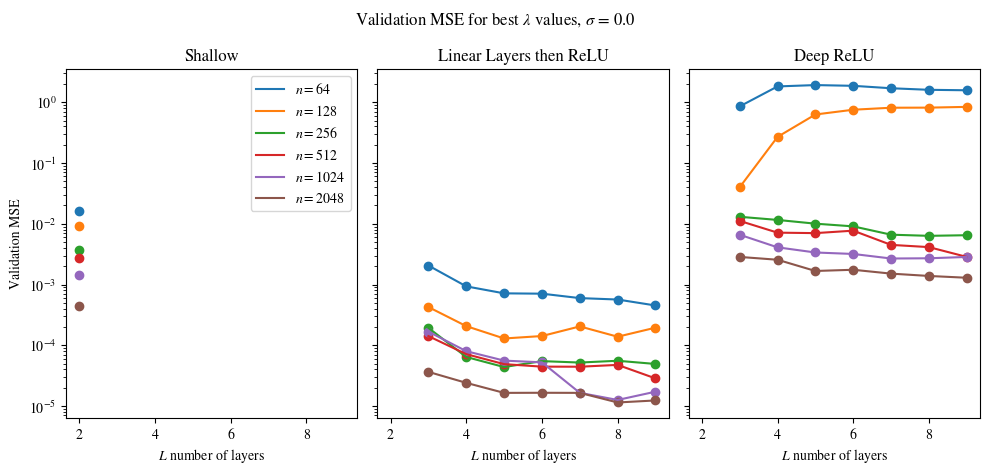

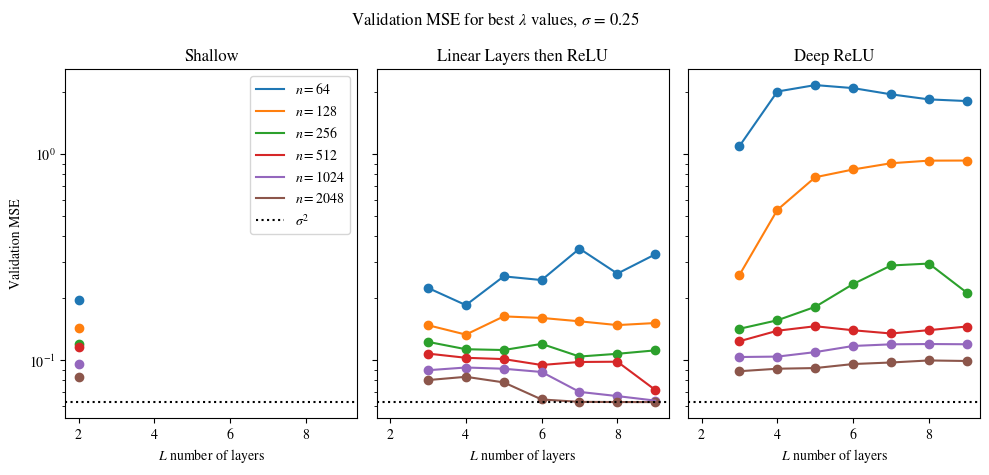

In [23]:
for std in res.sigma.unique():
    f, ax = plt.subplots(ncols=len(res.Activations.unique()),nrows=1, sharex=True, sharey=True, figsize=(10,4.8))
    for col,activation in enumerate(res.Activations.unique()):
        for n in res.n.unique():
                res_rnstd = res[(res.n == n) * (res["sigma"] == std) * (res.Activations == activation)]
                ax[col].scatter(res_rnstd.L,res_rnstd[["Validation MSE"]])
                ax[col].semilogy(res_rnstd.L,res_rnstd[["Validation MSE"]],label=rf"$n={n}$")
                for _,model in res_rnstd.iterrows():
                    text = rf'$\lambda = {model["lambda"]:.0e}$' + f'\nfit {model["Final Train MSE"]:.1e}\nwd{model["Final Weight Decay"]:.1e}'
        ax[col].set_xlabel("$L$ number of layers")
        ax[col].set_title(activation)
        if std > 0:
            ax[col].axhline(y=std**2, color='k', linestyle=':',label="$\sigma^2$")
        ax[0].set_ylabel("Validation MSE")
        f.suptitle(rf"Validation MSE for best $\lambda$ values, $\sigma$ = {std}")
    ax[0].legend()
    f.tight_layout()
    if int(std) == std:
        std = int(std)
    f.savefig("architecture_comparison"+f"_labelnoise{std}_ValidationMSE.pdf",dpi=300)
    plt.show()

## Performance metrics with/without linear layers

In [24]:
res.r.unique()

array([1])

In [25]:
res.Activations.unique()

array(['Shallow', 'Linear Layers then ReLU', 'Deep ReLU'], dtype=object)

In [26]:
columnwidth = 6.17406722223
markersize = 4
colors = {  
    0   :"C0",
    0.25:"C1",
}
linestyles = {
    "Shallow":"-",
    "Linear Layers then ReLU":"--",
    'Deep ReLU':"-.",
    'ReLU then Linear Layers then ReLU':(0, (3, 1, 1, 1, 1, 1))
}
markers = {
    "Shallow":".",
    "Linear Layers then ReLU":"x",
    'Deep ReLU':"^",
    'ReLU then Linear Layers then ReLU':"v"
}

### generalization

(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)


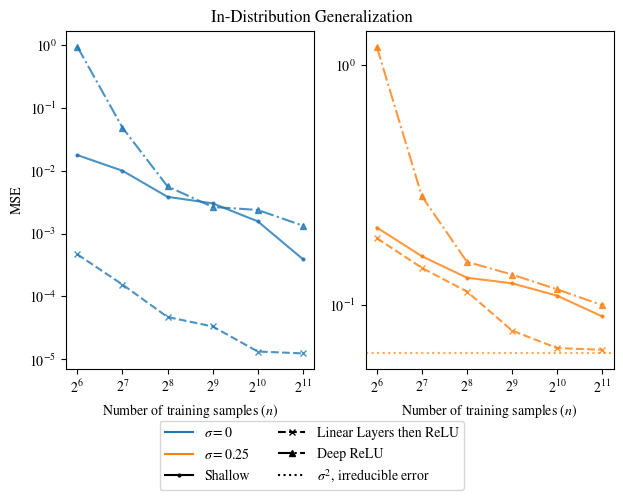

(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)
(6, 32)


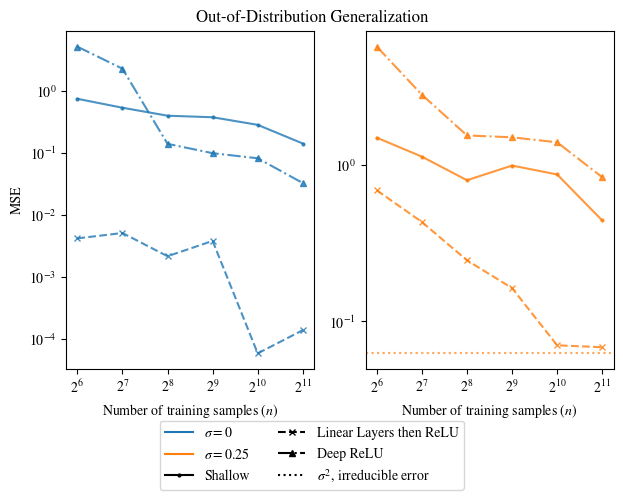

In [27]:
#generalization and OOD errors
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=linestyles[activation], label=activation, marker = markers[activation], markersize=markersize) for activation in res.Activations.unique()
] 
handles += [
        Line2D([0], [0], color='k', ls=':', label='$\sigma^2$, irreducible error'),
]

for metric in ['In-Distribution','Out-of-Distribution']:
    standard_errors = metric[:-3] + 'SEM'
    f, ax = plt.subplots(ncols=2,nrows=1, sharex=True, figsize=(columnwidth,4.25))
    #just the data without label noise in the first row
    for col,sigma in enumerate([0,0.25]):
        for activation in res.Activations.unique():
            curr = bestres[(bestres.Activations == activation) * (bestres.sigma == sigma)]
            print(curr.shape)
            points = curr[[metric + " MSE"]].values[:,0]
            ax[col].plot(curr.n,points,
                                linestyle=linestyles[activation],
                                marker=markers[activation],
                                markersize=markersize,
                                color=colors[sigma],
                                alpha=0.8)
            #horizontal dashed line for minimal possible MSE (ie sigma^2) in plots with label noise
            ax[1].axhline(y=sigma**2, color=colors[sigma], linestyle=':',alpha=0.3)
        #plot set up
        ax[col].set_xscale("log",base=2)
        ax[col].set_xticks([2**k for k in range(6,12)])
        ax[col].set_yscale("log",base=10)
        ax[0].set_ylabel(f"MSE",wrap=True)
        ax[col].set_xlabel("Number of training samples ($n$)")
        ax[col].minorticks_off()
    f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
    plt.suptitle(f"{metric} Generalization")
    plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
    plt.savefig("architecture_comparison"+f"{metric} Generalization.pdf",dpi=300,bbox_inches='tight')
    plt.show()

### singular values

Shallow 0.0 64
Linear Layers then ReLU 0.0 64
Deep ReLU 0.0 64
Shallow 0.25 64
Linear Layers then ReLU 0.25 64
Deep ReLU 0.25 64
Shallow 0.0 128
Linear Layers then ReLU 0.0 128
Deep ReLU 0.0 128
Shallow 0.25 128
Linear Layers then ReLU 0.25 128
Deep ReLU 0.25 128
Shallow 0.0 256
Linear Layers then ReLU 0.0 256
Deep ReLU 0.0 256
Shallow 0.25 256
Linear Layers then ReLU 0.25 256
Deep ReLU 0.25 256
Shallow 0.0 512
Linear Layers then ReLU 0.0 512
Deep ReLU 0.0 512
Shallow 0.25 512
Linear Layers then ReLU 0.25 512
Deep ReLU 0.25 512
Shallow 0.0 1024
Linear Layers then ReLU 0.0 1024
Deep ReLU 0.0 1024
Shallow 0.25 1024
Linear Layers then ReLU 0.25 1024
Deep ReLU 0.25 1024
Shallow 0.0 2048
Linear Layers then ReLU 0.0 2048
Deep ReLU 0.0 2048
Shallow 0.25 2048
Linear Layers then ReLU 0.25 2048
Deep ReLU 0.25 2048
Shallow 0.0 64
Linear Layers then ReLU 0.0 64
Deep ReLU 0.0 64
Shallow 0.25 64
Linear Layers then ReLU 0.25 64
Deep ReLU 0.25 64
Shallow 0.0 128
Linear Layers then ReLU 0.0 128
Deep Re

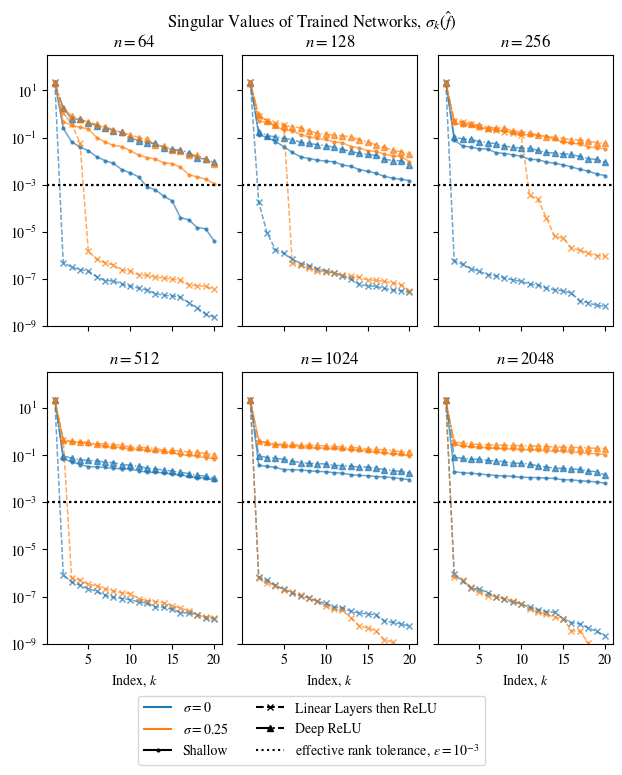

In [28]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=linestyles[activation], label=activation, marker = markers[activation], markersize=markersize) for activation in res.Activations.unique()
] 
handles += [Line2D([0], [0], color='k', ls=':', label=r"effective rank tolerance, $\varepsilon = 10^{-3}$")]

ranktol = 1e-3
f, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(columnwidth,7))#,5.75))
for activation in res.Activations.unique():
    for nnum,n in enumerate(res.n.unique()):
        row = nnum // 3
        col = nnum % 3
        for sigma in res.sigma.unique():
            for activation in res.Activations.unique():
                print(activation,sigma,n)
                curr = bestres[(bestres.Activations == activation) * (bestres.sigma == sigma) * (bestres.n == n)]
                ax[row,col].semilogy(curr["Gradient Singular Values"].values[0]/np.sqrt(2048),
                    linestyle=linestyles[activation],
                    linewidth=1,
                    alpha=0.3,
                    marker=markers[activation],
                    markersize=markersize,
                    color=colors[sigma])
        ax[row,col].axhline(y=ranktol, color='k', linestyle=':',alpha=1, label = r"effective rank tolerance, $\varepsilon = 10^{-3}$")
        ax[row,col].set_xticks(list(range(4,20,5)),list(range(5,21,5)))
        ax[0,0].set_yticks([10**p for p in range(-9,3,2)])
        ax[row,col].set_title(rf"$n={n}$")
        ax[-1,col].set_xlabel(rf"Index, $k$")
        ax[row,col].set_ylim(10**(-9),10**(2.5))
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.01))
plt.suptitle(r"Singular Values of Trained Networks, $\sigma_k(\hat{f})$")
plt.tight_layout(pad=0.5,h_pad=1.08, w_pad=1.08)
plt.savefig("architecture_comparison"+f"_labelnoise_sv.pdf",dpi=300, bbox_inches='tight')
plt.show()
handles.pop()

### active subspaces

0.0
0.25
0.0
0.25


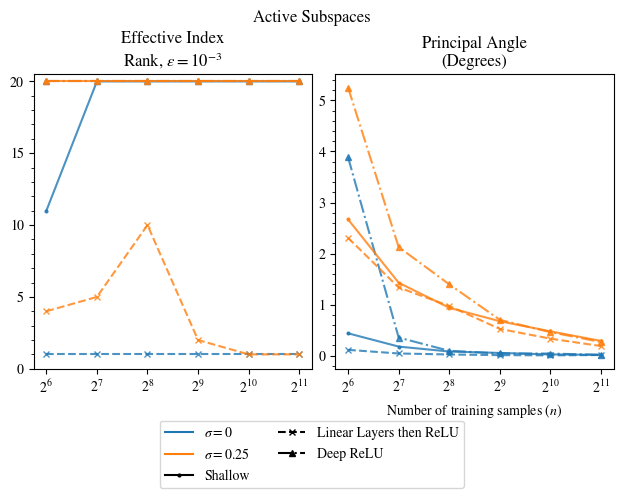

In [29]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=linestyles[activation], label=activation, marker = markers[activation], markersize=markersize) for activation in res.Activations.unique()
] 

#active subspace error plot
f, ax = plt.subplots(ncols=2,nrows=1, sharex=True, sharey=False, figsize=(columnwidth,4.25))
for col,metric in enumerate([r"Effective Index Rank, $\varepsilon = 10^{-3}$","Principal Angle (Degrees)"]):
    for sigma in res.sigma.unique():
        print(sigma)
        for activation in res.Activations.unique():
            curr = bestres[(bestres.Activations == activation) * (bestres.sigma == sigma)]
            if metric == "Principal Angle (Degrees)":
                points = curr[[metric]].values[:,0]
            elif metric == r"Effective Index Rank, $\varepsilon = 10^{-3}$":
                points = (np.array(curr["Gradient Singular Values"].tolist())/np.sqrt(2048) > ranktol).sum(axis=1)
                ax[col].set_yticks(np.arange(0,21,5))
                ax[col].set_ylim(0,20.5)
            ax[col].plot(curr.n,points,
                                linestyle=linestyles[activation],
                                color=colors[sigma],
                                marker=markers[activation],
                                markersize=markersize,
                                alpha=0.8)
    #plot set up
    ax[col].set_title(metric[:15] + '\n' + metric[16:])
    ax[0].set_yticks(range(21), minor=True)
    ax[col].set_xscale("log",base=2)
    ax[col].set_xticks([2**k for k in range(6,12)])
    ax[1].set_xlabel("Number of training samples ($n$)")
    ax[col].minorticks_on()
f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.03))
plt.suptitle(f"Active Subspaces")
plt.tight_layout(pad=0.5,h_pad=0.5, w_pad=0.5)
plt.savefig("architecture_comparison"+f"Active Subspaces.pdf",dpi=300,bbox_inches='tight')
plt.show()

## training

Shallow 0.0 64
Linear Layers then ReLU 0.0 64
Deep ReLU 0.0 64
Shallow 0.25 64
Linear Layers then ReLU 0.25 64
Deep ReLU 0.25 64
Shallow 0.0 128
Linear Layers then ReLU 0.0 128
Deep ReLU 0.0 128
Shallow 0.25 128
Linear Layers then ReLU 0.25 128
Deep ReLU 0.25 128
Shallow 0.0 256
Linear Layers then ReLU 0.0 256
Deep ReLU 0.0 256
Shallow 0.25 256
Linear Layers then ReLU 0.25 256
Deep ReLU 0.25 256
Shallow 0.0 512
Linear Layers then ReLU 0.0 512
Deep ReLU 0.0 512
Shallow 0.25 512
Linear Layers then ReLU 0.25 512
Deep ReLU 0.25 512
Shallow 0.0 1024
Linear Layers then ReLU 0.0 1024
Deep ReLU 0.0 1024
Shallow 0.25 1024
Linear Layers then ReLU 0.25 1024
Deep ReLU 0.25 1024
Shallow 0.0 2048
Linear Layers then ReLU 0.0 2048
Deep ReLU 0.0 2048
Shallow 0.25 2048
Linear Layers then ReLU 0.25 2048
Deep ReLU 0.25 2048


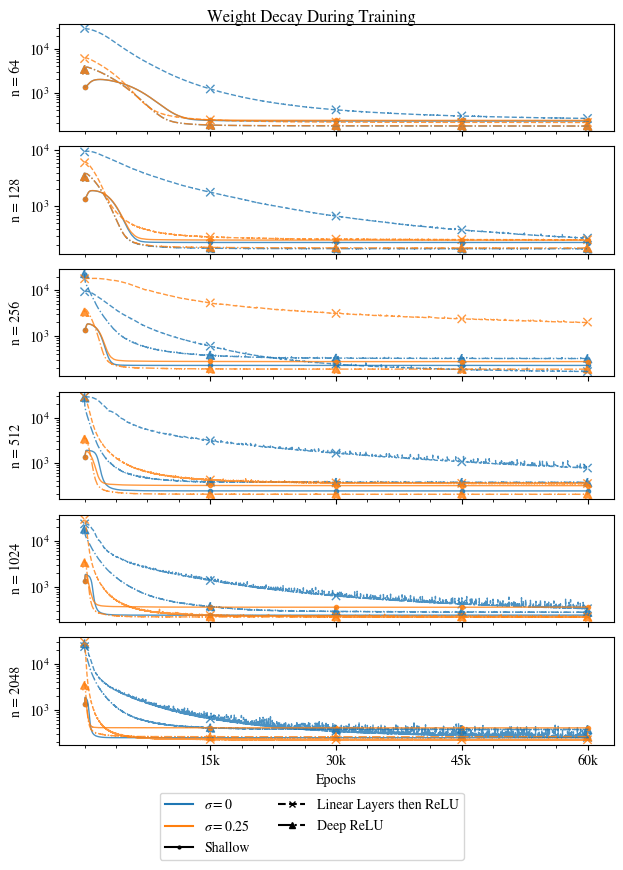

Shallow 0.0 64
Linear Layers then ReLU 0.0 64
Deep ReLU 0.0 64
Shallow 0.25 64
Linear Layers then ReLU 0.25 64
Deep ReLU 0.25 64
Shallow 0.0 128
Linear Layers then ReLU 0.0 128
Deep ReLU 0.0 128
Shallow 0.25 128
Linear Layers then ReLU 0.25 128
Deep ReLU 0.25 128
Shallow 0.0 256
Linear Layers then ReLU 0.0 256
Deep ReLU 0.0 256
Shallow 0.25 256
Linear Layers then ReLU 0.25 256
Deep ReLU 0.25 256
Shallow 0.0 512
Linear Layers then ReLU 0.0 512
Deep ReLU 0.0 512
Shallow 0.25 512
Linear Layers then ReLU 0.25 512
Deep ReLU 0.25 512
Shallow 0.0 1024
Linear Layers then ReLU 0.0 1024
Deep ReLU 0.0 1024
Shallow 0.25 1024
Linear Layers then ReLU 0.25 1024
Deep ReLU 0.25 1024
Shallow 0.0 2048
Linear Layers then ReLU 0.0 2048
Deep ReLU 0.0 2048
Shallow 0.25 2048
Linear Layers then ReLU 0.25 2048
Deep ReLU 0.25 2048


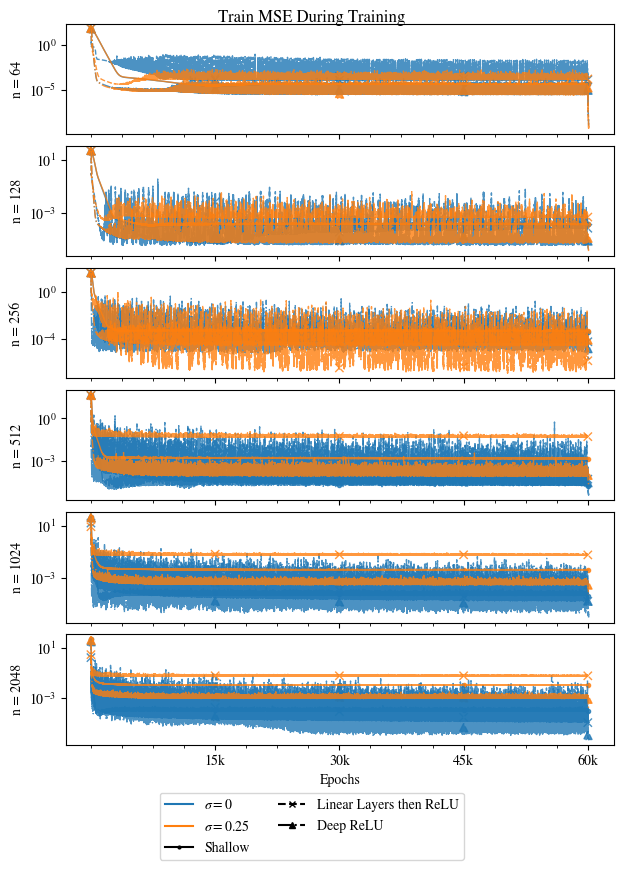

In [30]:
handles = [
    Line2D([0], [0], color=color, ls='-', label=rf"$\sigma =${sigma}") for sigma,color in colors.items()
]
handles += [
    Line2D([0], [0], color='k', ls=linestyles[activation], label=activation, marker = markers[activation], markersize=markersize) for activation in res.Activations.unique()
] 

#training time plot
for metric in ["Weight Decay","Train MSE"]:
    f, ax = plt.subplots(nrows=len(res.n.unique()), sharex=True, sharey=False, figsize=(columnwidth,8))
    for row,n in enumerate(res.n.unique()):
        for sigma in res.sigma.unique():
            for activation in res.Activations.unique():
                curr = bestres[(bestres.Activations == activation) * (bestres.sigma == sigma) * (bestres.n == n)]
                print(activation,sigma,n)
                assert curr[metric].shape[0] == 1 # make sure there's only one row
                values_to_plot = curr[metric].iloc[0]
                epochs = len(values_to_plot)
                ax[row].plot(np.arange(epochs),values_to_plot,
                                    linestyle=linestyles[activation],
                                    color=colors[sigma],
                                    linewidth = 1,
                                    alpha=0.8)
                ax[row].scatter(np.arange(epochs)[::15_000],values_to_plot[::15_000],
                                    linestyle=linestyles[activation],
                                    color=colors[sigma],
                                    marker=markers[activation],
                                    linewidth = 1,
                                    alpha=0.8)
            #plot set up
            ax[row].set_ylabel(f"n = {n}")
            ax[row].set_yscale("log",base=10)
            ax[row].minorticks_on()
            ax[-1].set_xlabel("Epochs")
            ticks = np.arange(15_000,epochs,step=15_000)
            ax[-1].set_xticks(ticks=ticks, labels=[str(t)[:-3]+'k' for t in ticks])
    f.legend(handles=handles, ncol=2, loc = 'upper center', bbox_to_anchor=(0.5,0.01))
    plt.suptitle(metric+" During Training")
    plt.tight_layout(pad=0.5,h_pad=0.5, w_pad=0.5)
    plt.savefig("architecture_comparison"+metric+"training.pdf",dpi=300,bbox_inches='tight')
    plt.show()